In [1]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer
from src.utils.display_utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions
from expr.expr_utils import generate_style_dict, KStyledMNISTGenerator, KStyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

In [5]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


### in distribution

In [6]:
np.random.seed(101)
torch.manual_seed(101)

In [7]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:16<00:00, 3602.86item/s]


### out-of-distribution

In [5]:
style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    corruptions.canny_edges,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]
K = 3

In [ ]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST("../data", train=True)
mnist_train, mnist_test = random_split(mnist, [50000, 10000])
style_dict = generate_style_dict(
    classes=list(range(10)), styles=list(range(len(style_fns))), k=K
)
mnist_generator = KStyledMNISTGenerator(mnist_train, style_fns, style_dict, "train")
train = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
mnist_generator = KStyledMNISTGenerator(mnist_test, style_fns, style_dict, "test")
test = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
train, valid = random_split(train, [0.85, 0.15])

In [ ]:
style_dict

### Experiment

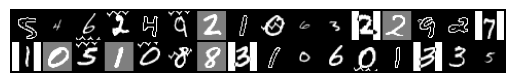

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, style = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


Hamaguchi, et al. (2019) state that the distance/similarity metric between two Gaussians is recommended to take both the $\mu$ and the $\Sigma$ into account. However, these unexpectedly lead to blurring in reconstruction and in turn result in lower gMIG. Therefore, we use `cosine` and `l2` in the constrastive loss.

### cosine sim + label-flipping

In [ ]:
Z_DIM = 16
TEMP = 0.3
ALPHA = 10000
PS = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "ps": PS},
    verbose_period=5,
    device=device,
)

In [31]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 195.15it/s]


val_recontr_loss=66.116, val_kl_c=9.887, val_kl_s=29.095, val_c_loss=0.617, val_s_loss=0.106
gMIG: 0.134; mse: 66.116


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 232.54it/s]


val_recontr_loss=35.917, val_kl_c=9.971, val_kl_s=38.128, val_c_loss=0.403, val_s_loss=0.107
gMIG: 0.231; mse: 35.917


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 238.52it/s]


val_recontr_loss=29.743, val_kl_c=11.339, val_kl_s=37.782, val_c_loss=0.372, val_s_loss=0.107
gMIG: 0.251; mse: 29.743


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 243.64it/s]


val_recontr_loss=27.936, val_kl_c=12.534, val_kl_s=38.946, val_c_loss=0.373, val_s_loss=0.107
gMIG: 0.253; mse: 27.936


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 238.61it/s]


val_recontr_loss=26.669, val_kl_c=14.876, val_kl_s=33.260, val_c_loss=0.354, val_s_loss=0.107
gMIG: 0.266; mse: 26.669


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 226.36it/s]


val_recontr_loss=26.342, val_kl_c=18.870, val_kl_s=34.975, val_c_loss=0.364, val_s_loss=0.107
gMIG: 0.286; mse: 26.342


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 222.88it/s]


val_recontr_loss=26.100, val_kl_c=17.761, val_kl_s=29.865, val_c_loss=0.353, val_s_loss=0.107
gMIG: 0.261; mse: 26.1


In [32]:
trainer.evaluate(test_loader, False, 0)

(0.2629707348299538, 25.972347259521484)

In [35]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 308.30it/s]


In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

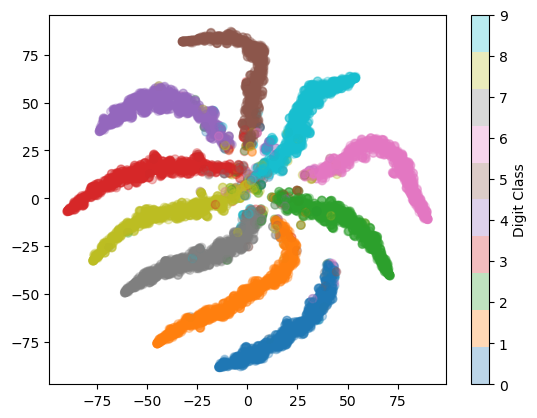

In [37]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

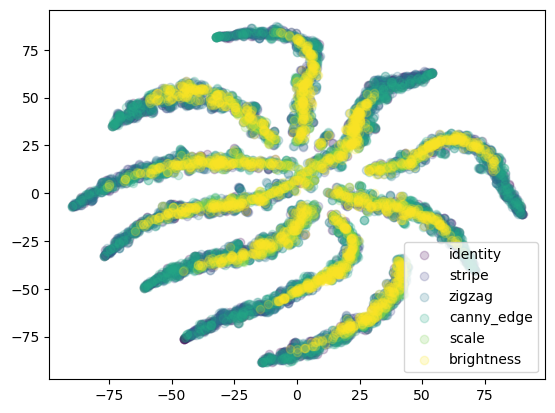

In [38]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [39]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

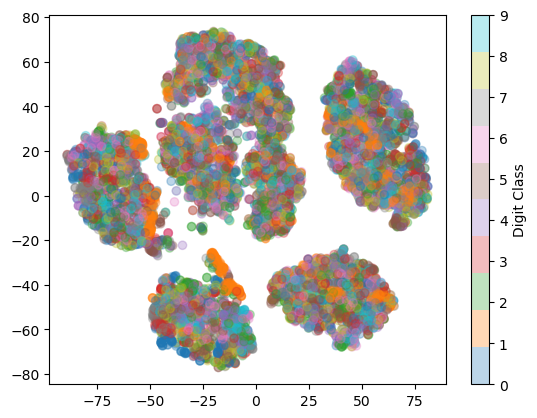

In [40]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

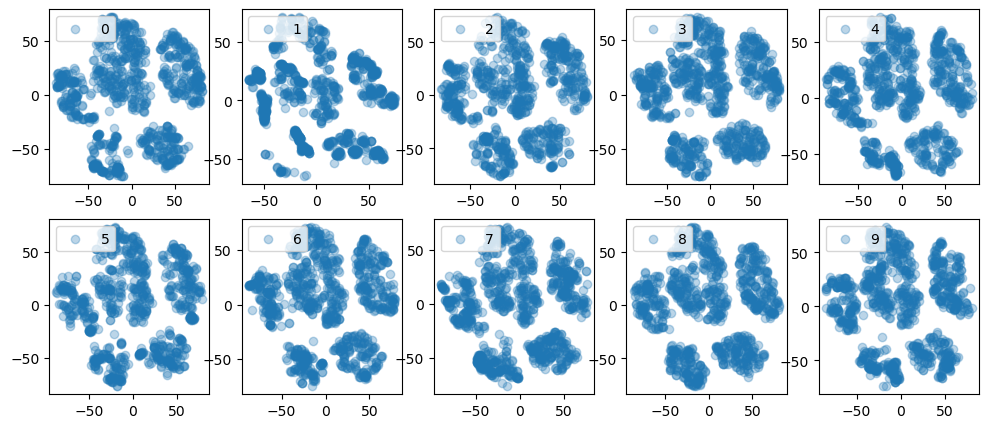

In [41]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

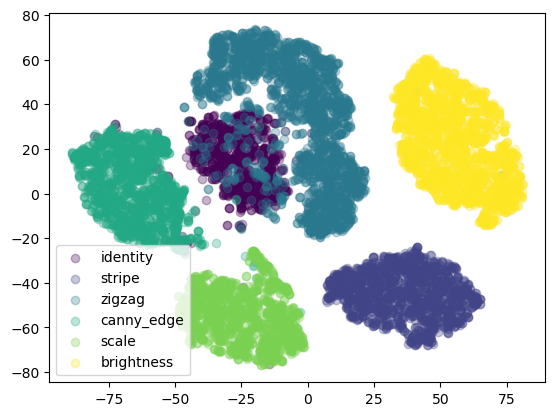

In [42]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [86]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


### l2 sim + lable-flipping

In [ ]:
Z_DIM = 16
TEMP = 0.3
ALPHA = 1e2
PS = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="l2",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "ps": PS},
    verbose_period=5,
    device=device,
)

In [21]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 250.62it/s]


val_recontr_loss=65.633, val_kl_c=8.768, val_kl_s=9.557, val_c_loss=0.338, val_s_loss=0.117
gMIG: 0.138; mse: 65.633


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 223.53it/s]


val_recontr_loss=34.074, val_kl_c=12.697, val_kl_s=15.935, val_c_loss=0.188, val_s_loss=0.117
gMIG: 0.243; mse: 34.074


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 231.30it/s]


val_recontr_loss=27.274, val_kl_c=13.570, val_kl_s=17.526, val_c_loss=0.181, val_s_loss=0.116
gMIG: 0.261; mse: 27.274


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 238.46it/s]


val_recontr_loss=24.357, val_kl_c=14.602, val_kl_s=18.479, val_c_loss=0.172, val_s_loss=0.112
gMIG: 0.265; mse: 24.357


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 233.62it/s]


val_recontr_loss=22.770, val_kl_c=15.229, val_kl_s=18.885, val_c_loss=0.185, val_s_loss=0.114
gMIG: 0.273; mse: 22.77


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 256.66it/s]


val_recontr_loss=21.208, val_kl_c=15.008, val_kl_s=19.604, val_c_loss=0.166, val_s_loss=0.113
gMIG: 0.273; mse: 21.208


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 249.56it/s]


val_recontr_loss=20.267, val_kl_c=16.338, val_kl_s=20.456, val_c_loss=0.162, val_s_loss=0.113
gMIG: 0.275; mse: 20.267


In [22]:
trainer.evaluate(test_loader, False, 0)

(0.27780471508735605, 20.140283584594727)

In [168]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [169]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 9
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### mahalanobis / modified l2 + label flipping

In [ ]:
Z_DIM = 16
TEMP = 10
ALPHA = 10
PS = True

In [ ]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="jeffrey",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "ps": PS},
    verbose_period=5,
    device=device,
)

In [32]:
trainer.fit(41, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 162.02it/s]


val_recontr_loss=51.460, val_kl_c=12.520, val_kl_s=12.426, val_c_loss=0.298, val_s_loss=0.143
gMIG: 0.196; mse: 51.46


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 160.94it/s]


val_recontr_loss=23.959, val_kl_c=12.998, val_kl_s=11.415, val_c_loss=0.184, val_s_loss=0.145
gMIG: 0.204; mse: 23.959


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 92.32it/s] 


val_recontr_loss=19.986, val_kl_c=14.458, val_kl_s=12.680, val_c_loss=0.195, val_s_loss=0.154
gMIG: 0.208; mse: 19.986


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 166.51it/s]


val_recontr_loss=17.956, val_kl_c=15.005, val_kl_s=12.871, val_c_loss=0.181, val_s_loss=0.161
gMIG: 0.21; mse: 17.956


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 158.85it/s]


val_recontr_loss=17.571, val_kl_c=15.176, val_kl_s=12.137, val_c_loss=0.199, val_s_loss=0.142
gMIG: 0.21; mse: 17.571


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 174.85it/s]


val_recontr_loss=16.757, val_kl_c=15.648, val_kl_s=12.421, val_c_loss=0.221, val_s_loss=0.146
gMIG: 0.216; mse: 16.757


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 168.85it/s]


val_recontr_loss=16.472, val_kl_c=15.777, val_kl_s=12.261, val_c_loss=0.203, val_s_loss=0.145
gMIG: 0.216; mse: 16.472


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 237.91it/s]


val_recontr_loss=15.924, val_kl_c=15.870, val_kl_s=12.974, val_c_loss=0.195, val_s_loss=0.152
gMIG: 0.21; mse: 15.924


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 246.11it/s]


val_recontr_loss=15.736, val_kl_c=16.109, val_kl_s=12.699, val_c_loss=0.220, val_s_loss=0.144
gMIG: 0.217; mse: 15.736


In [33]:
trainer.evaluate(test_loader, False, 0)

(0.21484563454893546, 15.447798728942871)

In [101]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

In [ ]:
display_util(9, 16, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [91]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))